# 속보_종목별 모델 만들기
- DL 모델: LSTM, LSTM+CNN, Attention

In [ ]:
# 코랩에서 실행시 pyMySQL을 먼저 설치해야 한다
#!pip install JPype1
#!pip install konlpy
#!pip install pyMySQL
#!pip install -U finance-datareader
#!pip install attention

In [2]:
#-- Import packages --
import os
import numpy as np
import pandas as pd
#import FinanceDataReader as fdr
import sqlite3
from sqlalchemy import create_engine
#import konlpy
#from konlpy.tag import Okt
import pymysql
from os import replace
import requests
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm
from datetime import datetime
from sqlalchemy import create_engine
import ast
from os import replace
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import TextVectorization
import re
import string
import itertools
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Dropout, Activation \
                                  , Embedding, LSTM, Conv1D, MaxPooling1D
from tensorflow.keras.models import Sequential
from attention import Attention
import warnings
warnings.filterwarnings('ignore')
#-- Import packages :END --

In [ ]:
######################################################################

In [ ]:
# -- custom_standardization_fn() --------------------------------------------
# custom_표준화 함수
def custom_standardization_fn(string_tensor):
    lowercase_string = string_tensor # 영문의 경우 여기서 모두 소문자 처리, 한글은 필요없음
    return tf.strings.regex_replace(
        # 문장부호 처리: %와 .는 살리고 나머지는 제외
        lowercase_string, f"[{re.escape(string.punctuation.replace('%','').replace('.',''))}]", "") 
# -- custom_standardization_fn() :END----------------------------------------

# -- custom_split_fn()-------------------------------------------------------
# custom_토큰화 함수
def custom_split_fn(string_tensor):
    return tf.strings.split(string_tensor)  # 한글의 경우 형태소 분석 처리 해야 한다
# -- custom_split_fn() :END--------------------------------------------------
 

# custom 표준화, 토큰화 함수 지정해서 TextVectoriztion 생성하기 ---------------
text_vectorization = TextVectorization(
    # 정수 인덱스로 출력
    output_mode="int",
    # 표준화 함수를 custom_표준화 함수로 지정
    standardize=custom_standardization_fn,
    # 토큰화 함수를 custom_토큰화 함수로 지정
    split=custom_split_fn,
)
# custom 표준화, 토큰화 함수 지정해서 TextVectoriztion 생성하기 END------------

# 모델에 쓸 데이터 로더 함수
- load_data_il_B()  : 1/0
- load_data_il()    : U/H/D
- load_data_bun_B() : 1/0
- load_data_bun()   : U/H/D

In [3]:
#-- load_data_il_B() -----------------------------------------------------
# 일기준 데이터 로더: Binary 1/0 (U/D) 가져오기
def load_data_il_B(stock_code):
  # 실행확인을 위한 화면 출력
  #print(stock_code)
  # DB 연결 준비
  conn = pymysql.connect(host= '호스트이름', port = 포트번호, user="아이디", password="패스워드", db="DB이름", charset = 'utf8')
  # DB에서 종목 데이터  추출위한 sql 준비
  sql = f"SELECT x.* FROM {stock_code}_il_dataset x"
  # DB 검색결과를 dataframe에 저장
  il_data_df = pd.read_sql_query(sql, conn)
  # 컬럼 이름 정리
  il_data_df.columns= ['text','label']
  # 레이블 'H' 는 빼기, Up/Down만 남기기
  il_data_df = il_data_df[il_data_df['label'] != 'H']
  # 레이블 숫자로 변환 return
  il_data_df['label'] = il_data_df['label'].replace({'U': 1, 'D': 0})
  # DB close
  conn.close()
  # df 반환
  return il_data_df
#-- load_data_il_B() : END--------------------------------------------

#-- load_data_il() ---------------------------------------------------
# 일기준 데이터 로더: Ternary U/H/D 가져오기
def load_data_il(stock_code):
  # 실행확인을 위한 화면 출력
  #print(stock_code)
  # DB 연결 준비
  conn = pymysql.connect(host= '호스트이름', port = 포트번호, user="아이디", password="패스워드", db="DB이름", charset = 'utf8')
  # DB에서 종목 데이터  추출위한 sql 준비
  sql = f"SELECT x.* FROM {stock_code}_il_dataset x"
  # DB 검색결과를 dataframe에 저장
  il_data_df = pd.read_sql_query(sql, conn)
  # 컬럼 이름 정리
  il_data_df.columns= ['text','label']
  # 레이블 숫자로 변환 return
  #il_data_df['label'] = il_data_df['label'].replace({'U': 3, 'H': 2, 'D': 1})
  # DB close
  conn.close()
  # df 반환
  return il_data_df
#-- load_data_il() :End-----------------------------------------------

#-- load_data_bun_B() ------------------------------------------------
# 분기준 데이터 로더: Binary 1/0 (U/D) 가져오기
def load_data_bun_B(stock_code):
  # 실행확인을 위한 화면 출력
  #print(stock_code)
  # DB 연결 준비
  conn = pymysql.connect(host= '호스트이름', port = 포트번호, user="아이디", password="패스워드", db="DB이름", charset = 'utf8')
  # DB에서 종목 데이터  추출위한 sql 준비
  sql = f"SELECT x.* FROM {stock_code}_bun_dataset x"
  # DB 검색결과를 dataframe에 저장
  il_data_df = pd.read_sql_query(sql, conn)
  # 컬럼 이름 정리
  il_data_df.columns= ['text','label']
  # Null 있는 행 삭제
  il_data_df = il_data_df.dropna()
  # 컬럼 이름 정리
  il_data_df.columns= ['text','label']
  # 레이블 'H' 는 빼기, Up/Down만 남기기
  il_data_df = il_data_df[il_data_df['label'] != 'H']
  # 레이블 숫자로 변환 return
  il_data_df['label'] = il_data_df['label'].replace({'U': 1, 'D': 0})
  # DB close
  conn.close()
  # df 반환
  return il_data_df
#-- load_data_bun_B() :End--------------------------------------------

#-- load_data_bun() --------------------------------------------------
# 분기준 데이터 로더: Ternary 2/1/0(U/H/D) 가져오기
def load_data_bun(stock_code):
  # 실행확인을 위한 화면 출력
  #print(stock_code)
  # DB 연결 준비
  conn = pymysql.connect(host= '호스트이름', port = 포트번호, user="아이디", password="패스워드", db="DB이름", charset = 'utf8')
  # DB에서 종목 데이터  추출위한 sql 준비
  sql = f"SELECT x.* FROM {stock_code}_bun_dataset x"
  # DB 검색결과를 dataframe에 저장
  il_data_df = pd.read_sql_query(sql, conn)
  # 컬럼 이름 정리
  il_data_df.columns= ['text','label']
  # Null 있는 행 삭제
  il_data_df = il_data_df.dropna()
  # 레이블 숫자로 변환 return
  il_data_df['label'] = il_data_df['label'].replace({'U': 2, 'H': 1, 'D': 0})
  # DB close
  conn.close()
  # df 반환
  return il_data_df
#-- load_data_bun() :End----------------------------------------------
#---------------------------------------------------------------------

In [ ]:
#-- 데이터 로더 확인
data_df = load_data_bun('005930')
data_df.info()

In [ ]:
########################################################################

#* LSTM 모델

In [4]:
# --LSTM_sokbo(stock_code,batch_size,epochs)---------------------------
# LSTM 카테고리 분류 모델 
def LSTM_sokbo(stock_code,batch_size,epochs):
  # data load
  bun_data_df = load_data_bun(stock_code)
  # 실행 확인을 위한 화면 출력
  print(bun_data_df.head(3))

  # data preparation: 데이터X,레이블y 분리
  X = bun_data_df['text']
  y = bun_data_df['label']

  # 문자열 형식인 데이터X를 리스트로 변환
  X= X.apply(lambda x: [int(i) for i in x.strip('[]').split()])

  # data set separation: 학습셋, 테스트셋 분리
  X_train, X_test,y_train, y_test = train_test_split(X,y,test_size=0.2, shuffle=True)

  # data print, data 확인
  # 레이블 카테고리 갯수 계산
  category = np.max(y_train) + 1
  # 실행 확인을 위한 화면 출력
  print(category,'카테고리')
  print(len(X_train),'학습용 뉴스 기사')
  print(len(X_test), '테스트용 뉴스 기사')
  print(X_train.at[0])

  # pad_sequence 단어 수 맞춰주기
  # 한 기사당 단어 갯수 제한
  sequence_length = 50
  X_train = sequence.pad_sequences(X_train, maxlen= sequence_length)
  X_test = sequence.pad_sequences(X_test,maxlen=sequence_length)

  # ** 레이블이 1/0 아닌 경우: 원핫 인코딩 처리
  y_train = to_categorical(y_train)
  y_test = to_categorical(y_test)

  # model creation: LSTM
  model = Sequential()
  model.add(Embedding(20000,sequence_length))         # Input : 임베딩(2만단어사전, 100단어)
  model.add(LSTM(sequence_length, activation='tanh')) # LSTM  : 활성화: tanh
  model.add(Dense(category, activation='softmax'))    # Output: ternary 이상인 경우
  #model.add(Dense(1, activation='sigmoid'))          # Output: binary인 경우

  # model compile, 실행 옵션
  model.compile(
      optimizer = 'adam'                    # 최적화 함수 : adam
    , loss = 'categorical_crossentropy'     # 손실 함수   : categorical_crossentropy(ternary 이상인 경우)
  # , loss = 'binary_crossentropy'          # 손실 함수   : binary_crossentropy(binary인 경우)
    , metrics = ['accuracy']                # 측정 지표   : 정확도 accuracy
  )

  # 조기중단 설정, early stopping callback
  early_stopping_callback = EarlyStopping(
      monitor= 'val_loss'                   # 모니터 항목 : val_loss
    , patience = 10                          # patiencd    : 5 (epochs)
  )

  # 최적화 모델 저장, best model saving checkpoint
  modelpath = f'./data/model/LSTM_sokbo_{stock_code}_b{batch_size}_e{epochs}_c{category}2.hdf5' # 모델저장위치와 이름

  # checkpointer 생성
  checkpointer = ModelCheckpoint(
      filepath = modelpath        # filepath
    , monitor = 'val_loss'        # 모니터  : val_loss
    , verbose = 0                 # verbose : 0
    , save_best_only = True       # save_best_only: True
  )

  # model fit, 모델 학습 실행, history 저장
  history = model.fit(
          X_train                     # 학습 데이터
      ,   y_train                     # 레이블
      ,   batch_size = batch_size     # batch_size
      ,   epochs = epochs             # epochs    
      ,   validation_data = (X_test, y_test)    # validation_data
      ,   callbacks = [               # callbacks
              early_stopping_callback # 조기중단
            , checkpointer            # best model 저장
          ]
  )

  # 결과 시각화
  # 테스트 정확도 출력
  print(f'\n Test Accuracy: {model.evaluate(X_test,y_test)[1]:.4f}')

  # 검증셋과 학습셋의 오차를 저장
  y_vloss = history.history['val_loss']
  y_loss = history.history['loss']

  # 그래프 그리기
  # x축: 실행한 epochs 횟수
  x_len = np.arange(len(y_loss))
  # 선그래프: 테스트셋 손실, red
  plt.plot(x_len, y_vloss, marker='.',c='red',label='Testset_loss')
  # 선그래프: 학습셋 손실, blue
  plt.plot(x_len, y_loss, marker='.',c='blue', label='Trainset_loss')
  # 그래프 legend 추가, 위치 지정
  plt.legend(loc='upper right')
  # 그래프에 그리드 표시
  plt.grid()
  # x 축 레이블
  plt.xlabel('epoch')
  # y 축 레이블
  plt.ylabel('loss')
  # 그래프 화면에 출력
  plt.show()

# --LSTM_sokbo(stock_code,batch_size,epochs) :END ------------------------

#* LSTM+CNN 모델

In [5]:
# --LSTMCNN_sokbo(stock_code, batch_size, epochs) -------------------------
# LSTM 카테고리 분류
def LSTMCNN_sokbo(stock_code, batch_size, epochs):
  
  # 분석대상 종목 코드
  #stock_code = '034950'
  # data load
  bun_data_df = load_data_bun(stock_code)
  # 실행 확인을 위한 화면 출력
  print(bun_data_df.head(3))

  # data preparation: 데이터X,레이블y 분리
  X = bun_data_df['text']
  y = bun_data_df['label']

  # 문자열 형식인 데이터X를 리스트로 변환
  X= X.apply(lambda x: [int(i) for i in x.strip('[]').split()])

  # data set separation: 학습셋, 테스트셋 분리
  X_train, X_test,y_train, y_test = train_test_split(X,y,test_size=0.2, shuffle=True)

  # data print, data 확인
  # 레이블 카테고리 갯수 계산
  category = np.max(y_train) + 1
  # 실행 확인을 위한 화면 출력
  print(category,'카테고리')
  print(len(X_train),'학습용 뉴스 기사')
  print(len(X_test), '테스트용 뉴스 기사')
  print(X_train[0])

  # pad_sequence 단어 수 맞춰주기
  # 한 기사당 단어 갯수 제한
  sequence_length = 50
  X_train = sequence.pad_sequences(X_train, maxlen= sequence_length)
  X_test = sequence.pad_sequences(X_test,maxlen=sequence_length)

  # ** 레이블이 1/0 아닌 경우: 원핫 인코딩 처리
  y_train = to_categorical(y_train)
  y_test = to_categorical(y_test)

  # model creation
  model = Sequential()
  model.add(Embedding(20000,sequence_length))         # Input : 임베딩(2만단어사전, 50단어)
  model.add(Dropout(0.5))
  model.add(Conv1D(64,5,padding='valid',activation='relu',strides=2))
  model.add(MaxPooling1D(pool_size=2))
  model.add(LSTM(64)) # LSTM  : 활성화: tanh
  model.add(Dense(category, activation='softmax'))    # Output: ternary 이상인 경우
  #model.add(Dense(1, activation='sigmoid'))          # Output: binary인 경우

  # model compile, 실행 옵션
  model.compile(
      optimizer = 'adam'                    # 최적화 함수 : adam
    , loss = 'categorical_crossentropy'     # 손실 함수   : categorical_crossentropy(ternary 이상인 경우)
  # , loss = 'binary_crossentropy'          # 손실 함수   : binary_crossentropy(binary인 경우)
    , metrics = ['accuracy']                # 측정 지표   : 정확도 accuracy
  )

  # 조기중단 설정, early stopping callback
  early_stopping_callback = EarlyStopping(
      monitor= 'val_loss'                   # 모니터 항목 : val_loss
    , patience = 10                          # patiencd    : 5 (epochs)
  )

  # 최적화 모델 저장, best model saving checkpoint
  modelpath = f'./data/model/LSTMCNN_sokbo_{stock_code}_b{batch_size}_e{epochs}_c{category}.hdf5' # 모델저장위치와 이름

  # checkpointer 생성
  checkpointer = ModelCheckpoint(
      filepath = modelpath        # filepath
    , monitor = 'val_loss'        # 모니터  : val_loss
    , verbose = 0                 # verbose : 0
    , save_best_only = True       # save_best_only: True
  )
  # model fit, 모델 학습 실행, history 저장
  history = model.fit(
          X_train                     # 학습 데이터
      ,   y_train                     # 레이블
      ,   batch_size = batch_size     # batch_size  : 24
      ,   epochs = epochs             # epochs      : 200
      ,   validation_data = (X_test, y_test)    # validation_data
      ,   callbacks = [               # callbacks
              early_stopping_callback # 조기중단
            , checkpointer            # best model
          ]
  )

  # 결과 시각화
  # 테스트 정확도 출력
  print(f'\n Test Accuracy: {model.evaluate(X_test,y_test)[1]:.4f}')

  # 검증셋과 학습셋의 오차를 저장
  y_vloss = history.history['val_loss']
  y_loss = history.history['loss']

  # 그래프 그리기
  # x축: 실행한 epochs 횟수
  x_len = np.arange(len(y_loss))
  # 선그래프: 테스트셋 손실, red
  plt.plot(x_len, y_vloss, marker='.',c='red',label='Testset_loss')
  # 선그래프: 학습셋 손실, blue
  plt.plot(x_len, y_loss, marker='.',c='blue', label='Trainset_loss')
  # 그래프 legend 추가, 위치 지정
  plt.legend(loc='upper right')
  # 그래프에 그리드 표시
  plt.grid()
  # x 축 레이블
  plt.xlabel('epoch')
  # y 축 레이블
  plt.ylabel('loss')
  # 그래프 화면에 출력
  plt.show()

# --LSTMCNN_sokbo(stock_code, batch_size, epochs) -------------------------

#* LSTM+Attention 모델

In [6]:
# --LSTMATT_sokbo(stock_code, batch_size, epochs)-------------
# LSTM+Attention 카테고리 분류
def LSTMATT_sokbo(stock_code, batch_size, epochs):
  
  # 분석대상 종목 코드
  #stock_code = '034950'
  # data load
  bun_data_df = load_data_bun(stock_code)
  # 실행 확인을 위한 화면 출력
  print(bun_data_df.head(3))

  # data preparation: 데이터X,레이블y 분리
  X = bun_data_df['text']
  y = bun_data_df['label']

  # 문자열 형식인 데이터X를 리스트로 변환
  X= X.apply(lambda x: [int(i) for i in x.strip('[]').split()])

  # data set separation: 학습셋, 테스트셋 분리
  X_train, X_test,y_train, y_test = train_test_split(X,y,test_size=0.2, shuffle=True)

  # data print, data 확인
  # 레이블 카테고리 갯수 계산
  category = np.max(y_train) + 1
  # 실행 확인을 위한 화면 출력
  print(category,'카테고리')
  print(len(X_train),'학습용 뉴스 기사')
  print(len(X_test), '테스트용 뉴스 기사')
  #print(X_train[0])

  # pad_sequence 단어 수 맞춰주기
  # 한 기사당 단어 갯수 제한
  sequence_length = 50
  X_train = sequence.pad_sequences(X_train, maxlen= sequence_length)
  X_test = sequence.pad_sequences(X_test,maxlen=sequence_length)

  # ** 레이블이 1/0 아닌 경우: 원핫 인코딩 처리
  y_train = to_categorical(y_train)
  y_test = to_categorical(y_test)

  # model creation
  model = Sequential()
  model.add(Embedding(20000,sequence_length))
  model.add(Dropout(0.5))
  model.add(LSTM(64, return_sequences=True))
  model.add(Attention())
  model.add(Dense(category, activation='softmax'))    # Output: ternary 이상인 경우

  # model compile, 실행 옵션
  model.compile(
      optimizer = 'adam'                    # 최적화 함수 : adam
    , loss = 'categorical_crossentropy'     # 손실 함수   : categorical_crossentropy(ternary 이상인 경우)
  # , loss = 'binary_crossentropy'          # 손실 함수   : binary_crossentropy(binary인 경우)
    , metrics = ['accuracy']                # 측정 지표   : 정확도 accuracy
  )

  # 조기중단 설정, early stopping callback
  early_stopping_callback = EarlyStopping(
      monitor= 'val_loss'                   # 모니터 항목 : val_loss
    , patience = 10                          # patiencd    : 5 (epochs)
  )

  # 최적화 모델 저장, best model saving checkpoint
  modelpath = f'./data/model/LSTMCNNATT_sokbo_{stock_code}_b{batch_size}_e{epochs}_c{category}.hdf5' # 모델저장위치와 이름

  # checkpointer 생성
  checkpointer = ModelCheckpoint(
      filepath = modelpath        # filepath
    , monitor = 'val_loss'        # 모니터  : val_loss
    , verbose = 0                 # verbose : 0
    , save_best_only = True       # save_best_only: True
  )
  # model fit, 모델 학습 실행, history 저장
  history = model.fit(
          X_train                     # 학습 데이터
      ,   y_train                     # 레이블
      ,   batch_size = batch_size     # batch_size  : 24
      ,   epochs = epochs             # epochs      : 200
      ,   validation_data = (X_test, y_test)    # validation_data
      ,   callbacks = [               # callbacks
              early_stopping_callback # 조기중단
            , checkpointer            # best model
          ]
  )

  # 결과 시각화
  # 테스트 정확도 출력
  print(f'\n Test Accuracy: {model.evaluate(X_test,y_test)[1]:.4f}')

  # 검증셋과 학습셋의 오차를 저장
  y_vloss = history.history['val_loss']
  y_loss = history.history['loss']

  # 그래프 그리기
  # x축: 실행한 epochs 횟수
  x_len = np.arange(len(y_loss))
  # 선그래프: 테스트셋 손실, red
  plt.plot(x_len, y_vloss, marker='.',c='red',label='Testset_loss')
  # 선그래프: 학습셋 손실, blue
  plt.plot(x_len, y_loss, marker='.',c='blue', label='Trainset_loss')
  # 그래프 legend 추가, 위치 지정
  plt.legend(loc='upper right')
  # 그래프에 그리드 표시
  plt.grid()
  # x 축 레이블
  plt.xlabel('epoch')
  # y 축 레이블
  plt.ylabel('loss')
  # 그래프 화면에 출력
  plt.show()
# --LSTMATT_sokbo(stock_code, batch_size, epochs)-------------

#* Transformer 모델

In [21]:
# -- TFMR_sokbo(stock_code, batch_size, epochs)--------------------
def TFMR_sokbo(stock_code, batch_size, epochs):
  import tensorflow as tf
  from tensorflow.keras.models import Model
  from tensorflow.keras.layers import Input, Embedding, GlobalAveragePooling1D, Dense, Dropout, LayerNormalization
  from tensorflow.keras.optimizers import Adam
  from tensorflow.keras.losses import SparseCategoricalCrossentropy
  from tensorflow.keras.metrics import SparseCategoricalAccuracy
  from sklearn.model_selection import train_test_split
  from tensorflow.keras.preprocessing import sequence
  from tensorflow.keras.utils import to_categorical
  from tensorflow.keras.layers import Dense, Dropout, Activation, Embedding, LSTM, Conv1D, MaxPooling1D
  from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
  from attention import Attention

  class MultiHeadSelfAttention(tf.keras.layers.Layer):
      def __init__(self, embed_dim, num_heads=8):
          super(MultiHeadSelfAttention, self).__init__()
          self.embed_dim = embed_dim
          self.num_heads = num_heads
          self.projection_dim = embed_dim // num_heads
          self.query_dense = tf.keras.layers.Dense(embed_dim)
          self.key_dense = tf.keras.layers.Dense(embed_dim)
          self.value_dense = tf.keras.layers.Dense(embed_dim)
          self.combine_heads = tf.keras.layers.Dense(embed_dim)

      def attention(self, query, key, value):
          score = tf.matmul(query, key, transpose_b=True)
          dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
          scaled_score = score / tf.math.sqrt(dim_key)
          weights = tf.nn.softmax(scaled_score, axis=-1)
          output = tf.matmul(weights, value)
          return output

      def separate_heads(self, x, batch_size):
          x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
          return tf.transpose(x, perm=[0, 2, 1, 3])

      def call(self, inputs):
          batch_size = tf.shape(inputs)[0]
          query = self.query_dense(inputs)
          key = self.key_dense(inputs)
          value = self.value_dense(inputs)
          query = self.separate_heads(query, batch_size)
          key = self.separate_heads(key, batch_size)
          value = self.separate_heads(value, batch_size)
          attention = self.attention(query, key, value)
          attention = tf.transpose(attention, perm=[0, 2, 1, 3])
          concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))
          output = self.combine_heads(concat_attention)
          return output

  def transformer_encoder(inputs, embed_dim, num_heads, ff_dim, rate=0.1):
      attn = MultiHeadSelfAttention(embed_dim, num_heads)(inputs)
      attn = Dropout(rate)(attn)
      out = LayerNormalization(epsilon=1e-6)(inputs + attn)
      ffn = tf.keras.Sequential(
          [Dense(ff_dim, activation="relu"), Dense(embed_dim),]
      )
      ffn_output = ffn(out)
      ffn_output = Dropout(rate)(ffn_output)
      out = LayerNormalization(epsilon=1e-6)(out + ffn_output)
      return out

  # Define Transformer model
  def build_transformer_model(max_seq_length, vocab_size, embed_dim, num_heads, ff_dim, num_classes):
      inputs = Input(shape=(max_seq_length,))
      embedding_layer = Embedding(input_dim=vocab_size, output_dim=embed_dim)(inputs)
      transformer_block = transformer_encoder(embedding_layer, embed_dim, num_heads, ff_dim)
      pool = GlobalAveragePooling1D()(transformer_block)
      outputs = Dense(num_classes, activation='softmax')(pool)
      model = Model(inputs=inputs, outputs=outputs)
      return model

  # Define hyperparameters
  max_seq_length = 50
  vocab_size = 20000
  embed_dim = 50
  num_heads = 5
  ff_dim = 128
  num_classes = 3
  learning_rate = 1e-4

  # Build and compile the model
  transformer_model = build_transformer_model(max_seq_length, vocab_size, embed_dim, num_heads, ff_dim, num_classes)
  optimizer = Adam(learning_rate=learning_rate)
  loss_fn = SparseCategoricalCrossentropy()
  accuracy_metric = SparseCategoricalAccuracy()

  transformer_model.compile(optimizer=optimizer, loss=loss_fn, metrics=[accuracy_metric])

  # Print model summary
  # transformer_model.summary()

  # 분석대상 종목 코드
  #stock_code = '034950'
  # data load
  bun_data_df = load_data_bun(stock_code)
  # 실행 확인을 위한 화면 출력
  print(bun_data_df.head(3))

  # data preparation: 데이터X,레이블y 분리
  X = bun_data_df['text']
  y = bun_data_df['label']

  # 문자열 형식인 데이터X를 리스트로 변환
  X= X.apply(lambda x: [int(i) for i in x.strip('[]').split()])

  # data set separation: 학습셋, 테스트셋 분리
  X_train, X_test,y_train, y_test = train_test_split(X,y,test_size=0.2, shuffle=True)

  # data print, data 확인
  # 레이블 카테고리 갯수 계산
  category = np.max(y_train) + 1
  # 실행 확인을 위한 화면 출력
  print(category,'카테고리')
  print(len(X_train),'학습용 뉴스 기사')
  print(len(X_test), '테스트용 뉴스 기사')
  #print(X_train.at[0])

  # pad_sequence 단어 수 맞춰주기
  # 한 기사당 단어 갯수 제한
  sequence_length = 50
  X_train = sequence.pad_sequences(X_train, maxlen= sequence_length)
  X_test = sequence.pad_sequences(X_test,maxlen=sequence_length)

  # ** 레이블이 1/0 아닌 경우: 원핫 인코딩 처리
  #y_train = to_categorical(y_train)
  #y_test = to_categorical(y_test)

  # 조기중단 설정, early stopping callback
  early_stopping_callback = EarlyStopping(
      monitor= 'val_loss'                   # 모니터 항목 : val_loss
    , patience = 10                          # patiencd    : 5 (epochs)
  )

  # 최적화 모델 저장, best model saving checkpoint
  modelpath = f'./data/model/TFMR_sokbo_{stock_code}_b{batch_size}_e{epochs}_c{category}.hdf5' # 모델저장위치와 이름

  # checkpointer 생성
  checkpointer = ModelCheckpoint(
      filepath = modelpath        # filepath
    , monitor = 'val_loss'        # 모니터  : val_loss
    , verbose = 0                 # verbose : 0
    , save_best_only = True       # save_best_only: True
  )
  # model fit, 모델 학습 실행, history 저장
  history = transformer_model.fit(
          X_train                     # 학습 데이터
      ,   y_train                     # 레이블
      ,   batch_size = batch_size     # batch_size  : 24
      ,   epochs = epochs             # epochs      : 200
      ,   validation_data = (X_test, y_test)    # validation_data
      ,   callbacks = [               # callbacks
              early_stopping_callback # 조기중단
            , checkpointer            # best model
          ]
  )

  # 결과 시각화
  # 테스트 정확도 출력
  print(f'\n Test Accuracy: {transformer_model.evaluate(X_test,y_test)[1]:.4f}')

  # 검증셋과 학습셋의 오차를 저장
  y_vloss = history.history['val_loss']
  y_loss = history.history['loss']

  # 그래프 그리기
  # x축: 실행한 epochs 횟수
  x_len = np.arange(len(y_loss))
  # 선그래프: 테스트셋 손실, red
  plt.plot(x_len, y_vloss, marker='.',c='red',label='Testset_loss')
  # 선그래프: 학습셋 손실, blue
  plt.plot(x_len, y_loss, marker='.',c='blue', label='Trainset_loss')
  # 그래프 legend 추가, 위치 지정
  plt.legend(loc='upper right')
  # 그래프에 그리드 표시
  plt.grid()
  # x 축 레이블
  plt.xlabel('epoch')
  # y 축 레이블
  plt.ylabel('loss')
  # 그래프 화면에 출력
  plt.show()
# -- TFMR_sokbo(stock_code, batch_size, epochs) :END------------------

                                                text  label
0  [ 18 179 122 9 3749 2377 52 241 3943 1 18 415 ...      2
1  [ 743 558 11 1 908 1 12992 581 580 25 91 245 2...      2
2  [ 10 187 589 1123 6 267 29 54 2 3004 44 2459 1...      2
3 카테고리
104308 학습용 뉴스 기사
26078 테스트용 뉴스 기사
[18, 179, 122, 9, 3749, 2377, 52, 241, 3943, 1, 18, 415, 3741, 1, 179, 122]
Epoch 1/200
1630/1630 [==============================] - 87s 52ms/step - loss: 1.0695 - accuracy: 0.4104 - val_loss: 1.0520 - val_accuracy: 0.4358
Epoch 2/200
1630/1630 [==============================] - 87s 53ms/step - loss: 0.9837 - accuracy: 0.5077 - val_loss: 1.0558 - val_accuracy: 0.4430
Epoch 3/200
1630/1630 [==============================] - 84s 51ms/step - loss: 0.8885 - accuracy: 0.5778 - val_loss: 1.0956 - val_accuracy: 0.4381
Epoch 4/200
1630/1630 [==============================] - 84s 52ms/step - loss: 0.7961 - accuracy: 0.6313 - val_loss: 1.1713 - val_accuracy: 0.4440
Epoch 5/200
1630/1630 [==============================] 

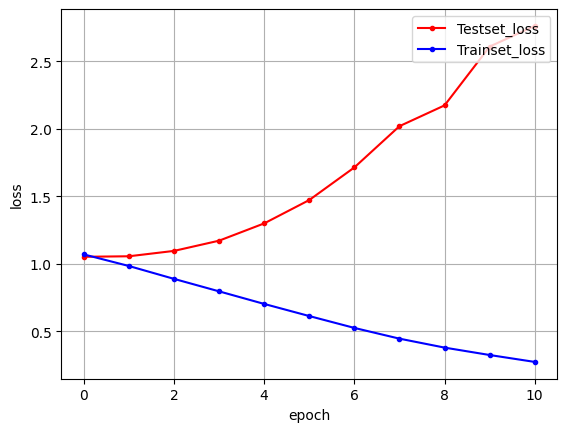

                                                text  label
0  [ 18 179 122 9 3749 2377 52 241 3943 1 18 415 ...      2
1  [ 743 558 11 1 908 1 12992 581 580 25 91 245 2...      2
2  [ 10 187 589 1123 6 267 29 54 2 3004 44 2459 1...      2
3 카테고리
104308 학습용 뉴스 기사
26078 테스트용 뉴스 기사
[18, 179, 122, 9, 3749, 2377, 52, 241, 3943, 1, 18, 415, 3741, 1, 179, 122]
Epoch 1/200
815/815 [==============================] - 63s 74ms/step - loss: 1.0709 - accuracy: 0.4083 - val_loss: 1.0461 - val_accuracy: 0.4478
Epoch 2/200
815/815 [==============================] - 60s 74ms/step - loss: 0.9881 - accuracy: 0.5039 - val_loss: 1.0525 - val_accuracy: 0.4441
Epoch 3/200
815/815 [==============================] - 58s 72ms/step - loss: 0.8989 - accuracy: 0.5695 - val_loss: 1.0823 - val_accuracy: 0.4437
Epoch 4/200
815/815 [==============================] - 59s 73ms/step - loss: 0.8098 - accuracy: 0.6238 - val_loss: 1.1600 - val_accuracy: 0.4418
Epoch 5/200
815/815 [==============================] - 60s 73ms

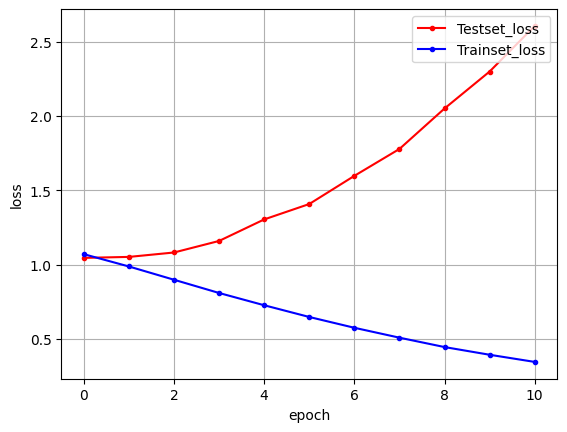

In [13]:
#===================================================================
# 메인 함수 실행: LSTM 모델 학습 예
#-------------------------------------------------------------------
#LSTM_sokbo('328380',32,200)
LSTM_sokbo('328380',64,200)
LSTM_sokbo('328380',128,200)
#==================================================================

                                                text  label
0  [ 18 179 122 9 3749 2377 52 241 3943 1 18 415 ...      2
1  [ 743 558 11 1 908 1 12992 581 580 25 91 245 2...      2
2  [ 10 187 589 1123 6 267 29 54 2 3004 44 2459 1...      2
3 카테고리
104308 학습용 뉴스 기사
26078 테스트용 뉴스 기사
[18, 179, 122, 9, 3749, 2377, 52, 241, 3943, 1, 18, 415, 3741, 1, 179, 122]
Epoch 1/200
3260/3260 [==============================] - 98s 29ms/step - loss: 1.0751 - accuracy: 0.4005 - val_loss: 1.0554 - val_accuracy: 0.4337
Epoch 2/200
3260/3260 [==============================] - 92s 28ms/step - loss: 1.0103 - accuracy: 0.4869 - val_loss: 1.0391 - val_accuracy: 0.4537
Epoch 3/200
3260/3260 [==============================] - 93s 29ms/step - loss: 0.9441 - accuracy: 0.5440 - val_loss: 1.0638 - val_accuracy: 0.4485
Epoch 4/200
3260/3260 [==============================] - 94s 29ms/step - loss: 0.8860 - accuracy: 0.5816 - val_loss: 1.0862 - val_accuracy: 0.4436
Epoch 5/200
3260/3260 [==============================] 

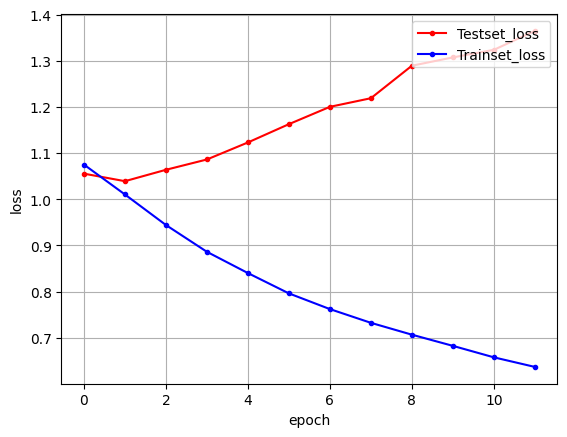

                                                text  label
0  [ 18 179 122 9 3749 2377 52 241 3943 1 18 415 ...      2
1  [ 743 558 11 1 908 1 12992 581 580 25 91 245 2...      2
2  [ 10 187 589 1123 6 267 29 54 2 3004 44 2459 1...      2
3 카테고리
104308 학습용 뉴스 기사
26078 테스트용 뉴스 기사
[18, 179, 122, 9, 3749, 2377, 52, 241, 3943, 1, 18, 415, 3741, 1, 179, 122]
Epoch 1/200
1630/1630 [==============================] - 65s 38ms/step - loss: 1.0757 - accuracy: 0.3968 - val_loss: 1.0540 - val_accuracy: 0.4344
Epoch 2/200
1630/1630 [==============================] - 64s 39ms/step - loss: 1.0098 - accuracy: 0.4858 - val_loss: 1.0480 - val_accuracy: 0.4464
Epoch 3/200
1630/1630 [==============================] - 64s 39ms/step - loss: 0.9407 - accuracy: 0.5433 - val_loss: 1.0558 - val_accuracy: 0.4442
Epoch 4/200
1630/1630 [==============================] - 58s 36ms/step - loss: 0.8799 - accuracy: 0.5841 - val_loss: 1.1032 - val_accuracy: 0.4375
Epoch 5/200
1630/1630 [==============================] 

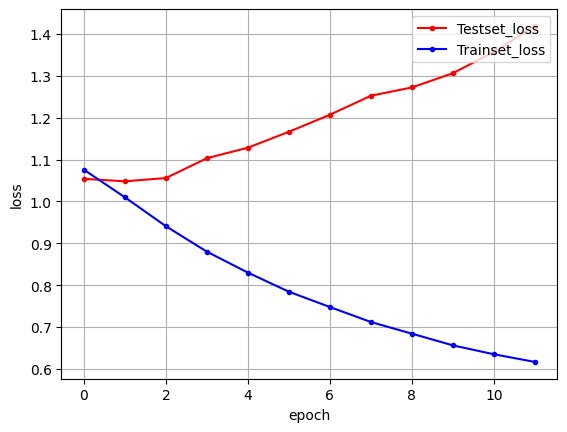

                                                text  label
0  [ 18 179 122 9 3749 2377 52 241 3943 1 18 415 ...      2
1  [ 743 558 11 1 908 1 12992 581 580 25 91 245 2...      2
2  [ 10 187 589 1123 6 267 29 54 2 3004 44 2459 1...      2
3 카테고리
104308 학습용 뉴스 기사
26078 테스트용 뉴스 기사
[18, 179, 122, 9, 3749, 2377, 52, 241, 3943, 1, 18, 415, 3741, 1, 179, 122]
Epoch 1/200
815/815 [==============================] - 49s 56ms/step - loss: 1.0773 - accuracy: 0.3964 - val_loss: 1.0544 - val_accuracy: 0.4362
Epoch 2/200
815/815 [==============================] - 43s 53ms/step - loss: 1.0119 - accuracy: 0.4814 - val_loss: 1.0446 - val_accuracy: 0.4472
Epoch 3/200
815/815 [==============================] - 42s 52ms/step - loss: 0.9436 - accuracy: 0.5405 - val_loss: 1.0651 - val_accuracy: 0.4439
Epoch 4/200
815/815 [==============================] - 43s 53ms/step - loss: 0.8826 - accuracy: 0.5822 - val_loss: 1.0913 - val_accuracy: 0.4393
Epoch 5/200
815/815 [==============================] - 42s 52ms

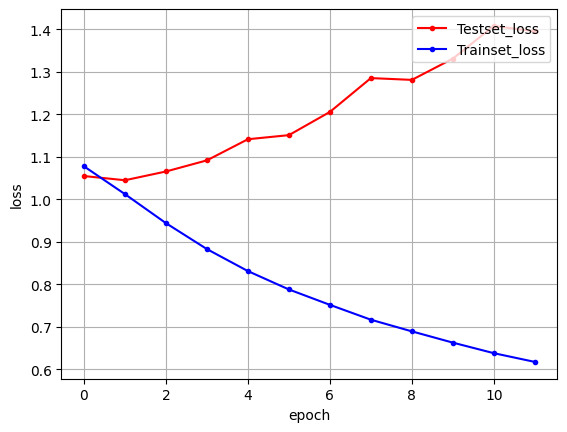

In [14]:
#===================================================================
# 메인 함수 실행: LSTMCNN 모델 학습 예
#-------------------------------------------------------------------
LSTMCNN_sokbo('328380',32,200)
LSTMCNN_sokbo('328380',64,200)
LSTMCNN_sokbo('328380',128,200)
#===================================================================

                                                text  label
0  [ 18 179 122 9 3749 2377 52 241 3943 1 18 415 ...      2
1  [ 743 558 11 1 908 1 12992 581 580 25 91 245 2...      2
2  [ 10 187 589 1123 6 267 29 54 2 3004 44 2459 1...      2
3 카테고리
104308 학습용 뉴스 기사
26078 테스트용 뉴스 기사
Epoch 1/200
3260/3260 [==============================] - 172s 52ms/step - loss: 1.0719 - accuracy: 0.4043 - val_loss: 1.0498 - val_accuracy: 0.4340
Epoch 2/200
3260/3260 [==============================] - 168s 52ms/step - loss: 1.0007 - accuracy: 0.4921 - val_loss: 1.0361 - val_accuracy: 0.4485
Epoch 3/200
3260/3260 [==============================] - 170s 52ms/step - loss: 0.9408 - accuracy: 0.5387 - val_loss: 1.0504 - val_accuracy: 0.4489
Epoch 4/200
3260/3260 [==============================] - 167s 51ms/step - loss: 0.8912 - accuracy: 0.5749 - val_loss: 1.0742 - val_accuracy: 0.4431
Epoch 5/200
3260/3260 [==============================] - 171s 53ms/step - loss: 0.8470 - accuracy: 0.6015 - val_loss: 1.1211 - 

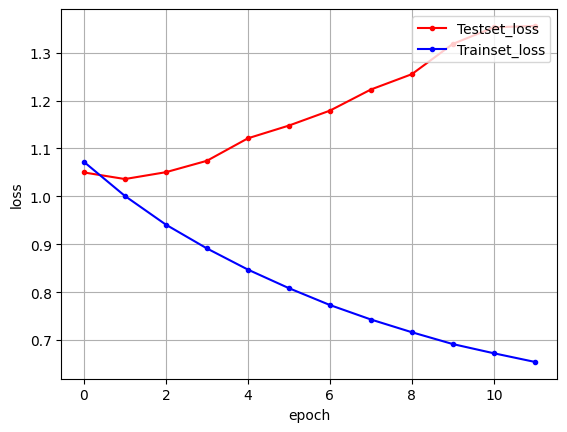

                                                text  label
0  [ 18 179 122 9 3749 2377 52 241 3943 1 18 415 ...      2
1  [ 743 558 11 1 908 1 12992 581 580 25 91 245 2...      2
2  [ 10 187 589 1123 6 267 29 54 2 3004 44 2459 1...      2
3 카테고리
104308 학습용 뉴스 기사
26078 테스트용 뉴스 기사
Epoch 1/200
1630/1630 [==============================] - 134s 80ms/step - loss: 1.0739 - accuracy: 0.4015 - val_loss: 1.0545 - val_accuracy: 0.4361
Epoch 2/200
1630/1630 [==============================] - 119s 73ms/step - loss: 1.0059 - accuracy: 0.4860 - val_loss: 1.0358 - val_accuracy: 0.4513
Epoch 3/200
1630/1630 [==============================] - 122s 75ms/step - loss: 0.9448 - accuracy: 0.5374 - val_loss: 1.0459 - val_accuracy: 0.4535
Epoch 4/200
1630/1630 [==============================] - 115s 70ms/step - loss: 0.8903 - accuracy: 0.5735 - val_loss: 1.0638 - val_accuracy: 0.4488
Epoch 5/200
1630/1630 [==============================] - 116s 71ms/step - loss: 0.8460 - accuracy: 0.6002 - val_loss: 1.1101 - 

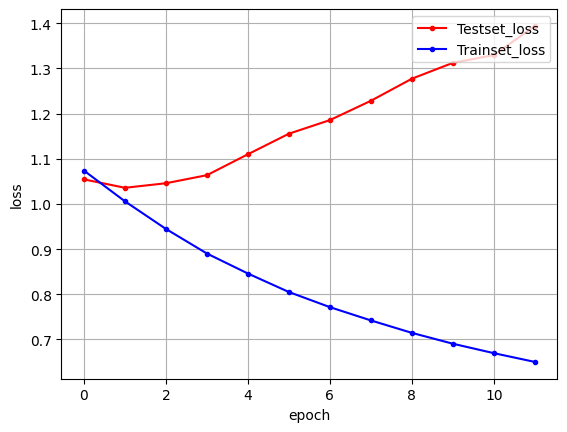

                                                text  label
0  [ 18 179 122 9 3749 2377 52 241 3943 1 18 415 ...      2
1  [ 743 558 11 1 908 1 12992 581 580 25 91 245 2...      2
2  [ 10 187 589 1123 6 267 29 54 2 3004 44 2459 1...      2
3 카테고리
104308 학습용 뉴스 기사
26078 테스트용 뉴스 기사
Epoch 1/200
815/815 [==============================] - 105s 125ms/step - loss: 1.0740 - accuracy: 0.4026 - val_loss: 1.0524 - val_accuracy: 0.4348
Epoch 2/200
815/815 [==============================] - 103s 126ms/step - loss: 1.0066 - accuracy: 0.4864 - val_loss: 1.0412 - val_accuracy: 0.4478
Epoch 3/200
815/815 [==============================] - 104s 127ms/step - loss: 0.9468 - accuracy: 0.5332 - val_loss: 1.0560 - val_accuracy: 0.4468
Epoch 4/200
815/815 [==============================] - 105s 128ms/step - loss: 0.8962 - accuracy: 0.5693 - val_loss: 1.0843 - val_accuracy: 0.4434
Epoch 5/200
815/815 [==============================] - 104s 127ms/step - loss: 0.8528 - accuracy: 0.5956 - val_loss: 1.1104 - val_a

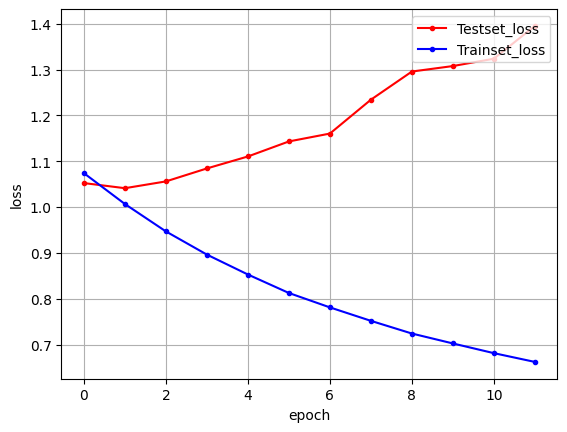

In [15]:
#===================================================================
# 메인 함수 실행: LSTMATT 모델 학습 예
#-------------------------------------------------------------------
LSTMATT_sokbo('328380',32,200)
LSTMATT_sokbo('328380',64,200)
LSTMATT_sokbo('328380',128,200)
#===================================================================

                                                text  label
0  [ 18 179 122 9 3749 2377 52 241 3943 1 18 415 ...      2
1  [ 743 558 11 1 908 1 12992 581 580 25 91 245 2...      2
2  [ 10 187 589 1123 6 267 29 54 2 3004 44 2459 1...      2
3 카테고리
104308 학습용 뉴스 기사
26078 테스트용 뉴스 기사
Epoch 1/200
3260/3260 [==============================] - 178s 48ms/step - loss: 1.0783 - sparse_categorical_accuracy: 0.3985 - val_loss: 1.0585 - val_sparse_categorical_accuracy: 0.4346
Epoch 2/200
3260/3260 [==============================] - 154s 47ms/step - loss: 1.0161 - sparse_categorical_accuracy: 0.4831 - val_loss: 1.0568 - val_sparse_categorical_accuracy: 0.4403
Epoch 3/200
3260/3260 [==============================] - 148s 45ms/step - loss: 0.9660 - sparse_categorical_accuracy: 0.5245 - val_loss: 1.0777 - val_sparse_categorical_accuracy: 0.4369
Epoch 4/200
3260/3260 [==============================] - 151s 46ms/step - loss: 0.9299 - sparse_categorical_accuracy: 0.5513 - val_loss: 1.0882 - val_sparse_cate

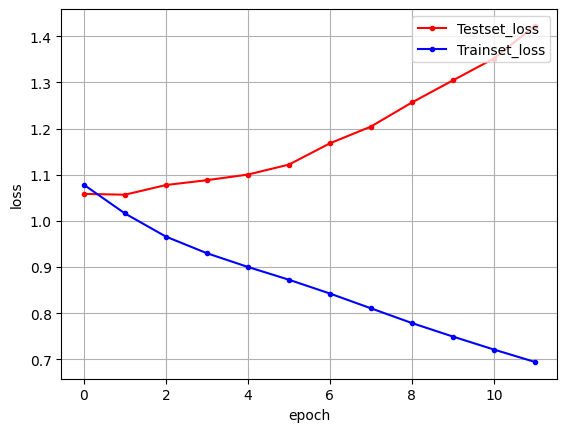

                                                text  label
0  [ 18 179 122 9 3749 2377 52 241 3943 1 18 415 ...      2
1  [ 743 558 11 1 908 1 12992 581 580 25 91 245 2...      2
2  [ 10 187 589 1123 6 267 29 54 2 3004 44 2459 1...      2
3 카테고리
104308 학습용 뉴스 기사
26078 테스트용 뉴스 기사
Epoch 1/200
1630/1630 [==============================] - 116s 70ms/step - loss: 1.0812 - sparse_categorical_accuracy: 0.3938 - val_loss: 1.0639 - val_sparse_categorical_accuracy: 0.4217
Epoch 2/200
1630/1630 [==============================] - 115s 71ms/step - loss: 1.0257 - sparse_categorical_accuracy: 0.4728 - val_loss: 1.0535 - val_sparse_categorical_accuracy: 0.4413
Epoch 3/200
1630/1630 [==============================] - 113s 69ms/step - loss: 0.9744 - sparse_categorical_accuracy: 0.5184 - val_loss: 1.0629 - val_sparse_categorical_accuracy: 0.4453
Epoch 4/200
1630/1630 [==============================] - 113s 69ms/step - loss: 0.9379 - sparse_categorical_accuracy: 0.5458 - val_loss: 1.0861 - val_sparse_cate

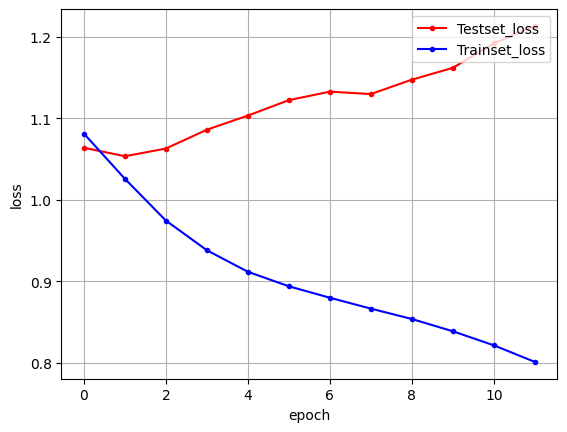

                                                text  label
0  [ 18 179 122 9 3749 2377 52 241 3943 1 18 415 ...      2
1  [ 743 558 11 1 908 1 12992 581 580 25 91 245 2...      2
2  [ 10 187 589 1123 6 267 29 54 2 3004 44 2459 1...      2
3 카테고리
104308 학습용 뉴스 기사
26078 테스트용 뉴스 기사
Epoch 1/200
815/815 [==============================] - 103s 123ms/step - loss: 1.0879 - sparse_categorical_accuracy: 0.3851 - val_loss: 1.0671 - val_sparse_categorical_accuracy: 0.4231
Epoch 2/200
815/815 [==============================] - 100s 122ms/step - loss: 1.0392 - sparse_categorical_accuracy: 0.4591 - val_loss: 1.0675 - val_sparse_categorical_accuracy: 0.4192
Epoch 3/200
815/815 [==============================] - 96s 117ms/step - loss: 0.9933 - sparse_categorical_accuracy: 0.5044 - val_loss: 1.0594 - val_sparse_categorical_accuracy: 0.4447
Epoch 4/200
815/815 [==============================] - 99s 122ms/step - loss: 0.9535 - sparse_categorical_accuracy: 0.5355 - val_loss: 1.0823 - val_sparse_categorica

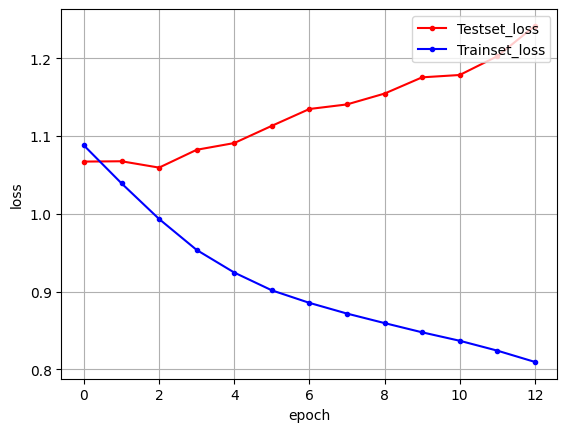

In [22]:
#===================================================================
# 메인 함수 실행: TFMR 모델 학습 예
#-------------------------------------------------------------------
TFMR_sokbo('328380',32,200)
TFMR_sokbo('328380',64,200)
TFMR_sokbo('328380',128,200)
#===================================================================